# Ground Plane Fitting and Scan Line Run for 3D LiDAR

Ground Plane Fitting (GPF) and Naive Baseline for 3D LiDAR Segmentation

This notebook implements ground segmentation using the Ground Plane Fitting (GPF) algorithm 
proposed in:

"Fast Segmentation of 3D Point Clouds: A Paradigm on LiDAR Data for Autonomous Vehicle Applications"
by D. Zermas, I. Izzat, and N. Papanikolopoulos, 2017.

The implementation also includes a naive baseline method for comparison, as well as 
basic clustering and visualization tools.

# Imports

In [507]:
import numpy as np
np.set_printoptions(threshold=2000)

from pypcd import pypcd  # Use local pypcd version (Python 3 compatible, no lzf support)
from sklearn.neighbors import KDTree # Used for spatial clustering
# Note: Ubuntu users may need to fix libz.so.1 symlink issue (see: https://github.com/heremaps/pptk/issues/3)
import pptk  # To install: pip install pptk
import os
from collections import defaultdict
from pathlib import Path
import numpy as np
import yaml

# Hyperparameters

In [508]:
# Number of lowest points to use for initial ground seed estimation (LPR)
NUM_LOWEST_POINTS = 1000

# Number of iterations for ground plane refinement
NUM_ITERATIONS = 5

# Height threshold above the LPR to select initial seed points
SEED_HEIGHT_THRESHOLD = 0.4

# Distance threshold to classify a point as ground
PLANE_DISTANCE_THRESHOLD = 0.2


RADIUS_FOR_NEAREST_NEIGHBORS = 0.5
MIN_POINTS_FOR_CLUSTER = 1

# Naive Baseline Method

In [509]:
def naive_ground_extractor(point_cloud, num_lowest_points):
    """
    Naive ground extraction method (baseline).
    
    This simple method selects the points with the lowest Z values 
    and assumes they belong to the ground surface. It does not model 
    the ground plane and is used as a baseline for comparison against 
    more robust algorithms like Ground Plane Fitting (GPF).
    
    Args:
        point_cloud (np.ndarray): N x D array of point cloud data.
        num_lowest_points (int): Number of points with lowest Z values to classify as ground.
    
    Returns:
        ground_indices (np.ndarray): Indices of the selected ground points.
    """

    # Select indices of points with the lowest Z values
    return np.argsort(point_cloud[:, 2])[:num_lowest_points]

# Ground Plane Fitting (GPF)

In [510]:
def extract_initial_seed_indices(point_cloud, num_points=1000, height_threshold=0.4):
    """
    Extract initial seed points for ground plane estimation (GPF).
    
    Args:
        point_cloud (np.ndarray): N x 3 array of points (x, y, z).
        num_points (int): number of lowest Z points to average as LPR.
        height_threshold (float): threshold to select seeds close to LPR height.
    
    Returns:
        seeds_ids (np.ndarray): indices of points selected as initial seeds.
    """

    # Step 1: Sort the point cloud by Z axis (height)
    sorted_indices = np.argsort(point_cloud[:, 2])  # Get indices sorted by height
    sorted_points = point_cloud[sorted_indices]     # Apply sorting

    # Step 2: Compute LPR (Lowest Point Representative)
    lpr_height = np.mean(sorted_points[:num_points, 2])

    # Step 3: Select point ids that are within threshold distance from LPR
    mask = sorted_points[:, 2] < (lpr_height + height_threshold)
    return sorted_indices[mask]

In [511]:
def estimate_ground_plane(points):
    """
    Estimate the ground plane parameters using Singular Value Decomposition (SVD).
    
    Args:
        points (np.ndarray): N x 3 array of seed points assumed to be on or near the ground.

    Returns:
        tuple: 
            - normal (np.ndarray): 3D normal vector of the estimated ground plane.
            - d (float): Plane offset (bias) from origin.
    """
    
    # Step 1: Compute centroid of the seed points
    centroid  = np.mean(points, axis=0)
    centered_points  = points - centroid 

    # Step 2: Compute the covariance matrix of centered points
    covariance_matrix = np.cov(centered_points.T)

    # Step 3: Perform SVD on the covariance matrix to extract principal directions
    _, _, vh = np.linalg.svd(covariance_matrix)

    # Step 4: Normal vector is the direction with smallest variance (last column of V^T)
    normal = vh[-1]

    # Step 5: Compute plane bias using point-normal form: ax + by + cz + d = 0
    d = -np.dot(normal, centroid)

    return normal, d

In [512]:
def refine_ground_plane(point_cloud, 
                        num_points=1000, 
                        height_threshold=0.4, 
                        distance_threshold=0.2, 
                        num_iterations=5):
    """
    Iteratively refine the ground plane estimation using seed points and distance threshold.
    
    Args:
        point_cloud (np.ndarray): N x 6 array representing the input point cloud, where each row contains:
            [x, y, z, true_label, predicted_label (to be set by algorithm), scanline_index].
        num_points (int): Number of lowest Z points used to compute the initial ground seed height (LPR).
        height_threshold (float): Vertical distance threshold from the LPR used to select initial seed points.
        distance_threshold (float): Max allowed point-to-plane distance for a point to be considered ground.
        num_iterations (int): Number of iterations to refine the plane and ground classification.
    
    Returns:
        point_cloud (np.ndarray): Modified input array with ground points labeled (predicted_label column = 9).
        normal (np.ndarray): Normal vector (a, b, c) of the estimated ground plane.
        d (float): Offset term of the estimated plane equation (ax + by + cz + d = 0).
    """

    # Step 0: Use only XYZ for plane estimation
    xyz = point_cloud[:, :3]

    # Step 1: Get initial seed points based on lowest Z values
    seed_indices = extract_initial_seed_indices(xyz, num_points, height_threshold)

    for _ in range(num_iterations):
        # Step 2: Estimate ground plane using current seeds
        normal, d = estimate_ground_plane(xyz[seed_indices])

        # Step 3: Compute distances from all points to the estimated plane
        distances = np.abs(np.dot(xyz, normal) + d) / np.linalg.norm(normal)

        # Step 4: Classify as ground if within distance threshold
        is_ground = distances < distance_threshold

        # Step 5: Update seeds with newly classified ground points
        seed_indices = np.where(is_ground)[0]

    # Final ground classification using last iteration's result
    point_cloud[seed_indices, 4] = 9 # Set label = 9 for ground

    return point_cloud, normal, d

# Scan Line Run (SLR)

In [513]:
def cluster_connected_components(points, eps=0.5, min_samples=1):
    """
    Cluster points into connected components using radius-based neighborhood and Union-Find.

    This method groups spatially connected points into clusters. It is a simplified version 
    of DBSCAN without density-based core points — it only relies on spatial proximity and 
    minimum cluster size filtering.

    Args:
        points (np.ndarray): N x 3 (or N x D) array of point coordinates.
        eps (float): Maximum distance between neighbors (radius in meters).
        min_samples (int): Minimum number of points to form a valid cluster.

    Returns:
        final_labels (np.ndarray): Cluster labels for each point (-1 for outliers).
    """
    # Step 1: Build neighborhood graph using radius search
    neighbors = NearestNeighbors(radius=eps).fit(points)
    adjacency = neighbors.radius_neighbors_graph(points, mode='connectivity').tocoo()

    # Step 2: Union-Find (Disjoint Set) initialization
    parent = np.arange(len(points))

    def find(i):
        # Path compression
        while parent[i] != i:
            parent[i] = parent[parent[i]]
            i = parent[i]
        return i

    def union(i, j):
        # Union by parent
        root_i, root_j = find(i), find(j)
        if root_i != root_j:
            parent[root_i] = root_j

    # Step 3: Connect all neighbors
    for i, j in zip(adjacency.row, adjacency.col):
        if i != j:
            union(i, j)

    # Step 4: Assign cluster labels
    labels = np.array([find(i) for i in range(len(points))])

    # Step 5: Filter small clusters (outliers)
    unique_labels, counts = np.unique(labels, return_counts=True)
    valid_labels = unique_labels[counts >= min_samples]
    mask = np.isin(labels, valid_labels)

    # Step 6: Remap valid clusters to consecutive indices, mark outliers as -1
    final_labels = -np.ones_like(labels)
    final_labels[mask] = np.searchsorted(valid_labels, labels[mask])
    return final_labels

In [514]:
def process_non_ground_clusters(point_cloud, eps=0.5, min_pts=1):
    """
    Apply spatial clustering to points not classified as ground.

    This function filters out ground points (using provided indices),
    and applies connected components clustering to the remaining non-ground points.

    Args:
        point_cloud (np.ndarray): N x 4 array with [x, y, z, class] per point.
        ground_indices (np.ndarray): Indices of points classified as ground.

    Returns:
        cluster_labels (np.ndarray): Cluster label for each non-ground point (-1 for noise).
        non_ground_indices (np.ndarray): Indices of the non-ground points in the original array.
    """

    # Step 1: Identify non-ground point indices
    non_ground_indices = np.where(point_cloud[:, 4] != 9)[0]

    # Step 2: Extract non-ground points for clustering
    non_ground_points = point_cloud[non_ground_indices, :3]  # Use only XYZ for clustering

    # Step 3: Apply spatial clustering to non-ground points
    cluster_labels = cluster_connected_components(non_ground_points, eps=eps, min_samples=min_pts)

    point_cloud[non_ground_indices, 4] = cluster_labels

    return point_cloud


# Scan Line Run (SLR) - igual original

In [515]:
def group_by_scanline(point_cloud):
    """
    Group points by their scanline index in a vectorized way.

    Args:
        point_cloud (np.ndarray): Nx6 array [x, y, z, true_label, pred_label, scanline_id].

    Returns:
        List[np.ndarray]: List of arrays. Each array contains the points (N_i x 6)
                          from one scanline, sorted by scanline_id.
    """
    scan_ids = point_cloud[:, 5].astype(int)
    unique_ids = np.unique(scan_ids)

    return [point_cloud[scan_ids == s_id] for s_id in unique_ids]

    # scanlines = defaultdict(list)

    # # Group each point by its scanline index
    # for point in point_cloud:
    #     scan_id = int(point[5])  # Extract scanline index from the 6th column
    #     scanlines[scan_id].append(point)

    # # Convert grouped lists to arrays, sorted by scanline index
    # return [np.array(scanlines[scan_id]) for scan_id in sorted(scanlines)]

In [516]:
def label_runs_circular_inplace(scanline, label_counter, dist_threshold=0.5):
    """
    Labels contiguous runs in a circular scanline, updating column 4 in-place (pred_label).

    Args:
        scanline (np.ndarray): Nx6 array [x, y, z, true_label, pred_label, scanline_id].
        label_counter (int): Current label to assign.
        dist_threshold (float): Distance threshold for considering points as a run.

    Returns:
        int: Updated label counter.
    """
    N = scanline.shape[0]
    if N == 0:
        return label_counter

    # Create an array of boolean flags for run boundaries
    breaks = np.zeros(N, dtype=bool)

    # Check distances between consecutive points
    for i in range(1, N):
        if np.linalg.norm(scanline[i, :3] - scanline[i - 1, :3]) > dist_threshold:
            breaks[i] = True

    # Check circular case: last point to first point
    circular_break = np.linalg.norm(scanline[0, :3] - scanline[-1, :3]) > dist_threshold
    if not circular_break:
        breaks[0] = False  # Ensure start is not a break if circular

    # Find indices where runs start
    run_start_indices = np.where(breaks)[0].tolist()
    run_start_indices.append(0)  # Always start a run at index 0
    run_start_indices = sorted(set(run_start_indices))

    # Close the circle: combine last and first run if needed
    if not circular_break and len(run_start_indices) > 1:
        # Merge first and last runs
        first_start = run_start_indices[0]
        last_start = run_start_indices[-1]
        scanline[[*range(last_start, N), *range(0, first_start)], 4] = label_counter
        label_counter += 1
        if label_counter == 9:
            label_counter += 1
        start_indices = run_start_indices[1:-1]  # Skip merged parts
    else:
        start_indices = run_start_indices

    # Label remaining runs
    for i in range(len(start_indices)):
        start = start_indices[i]
        end = start_indices[i + 1] if i + 1 < len(start_indices) else N
        scanline[start:end, 4] = label_counter
        label_counter += 1
        if label_counter == 9:
            label_counter += 1

    return label_counter

In [517]:
def label_runs(scanline, label_counter, dist_threshold=0.5):
    """
    Label contiguous runs of points within a single scanline using vectorized operations.

    Args:
        scanline (np.ndarray): Nx6 array [x, y, z, true_label, pred_label, scanline_id].
        label_counter (int): Initial label value to start labeling the runs.

    Returns:
        Tuple[np.ndarray, np.ndarray, int]:
            - run_points: Nx6 array with points from the scanline.
            - run_labels: (N,) array of assigned labels for each point in the scanline.
            - label_counter: Updated label counter.

        runs (List[Tuple[Tuple[float, ...], int]]): A list of tuples, where each tuple contains:
            - the point represented as a tuple
            - the assigned label
        label_counter (int): Updated label counter after labeling this scanline.
    """

    N = scanline.shape[0]
    if N == 0:
        return label_counter

    # Work only on points with label 0 (unlabeled)
    unlabeled_mask = scanline[:, 4] == 0
    indices = np.where(unlabeled_mask)[0]

    if len(indices) == 0:
        return label_counter

    current_label = label_counter
    start_idx = indices[0]

    for i in range(1, len(indices)):
        prev_idx = indices[i - 1]
        curr_idx = indices[i]

        dist = np.linalg.norm(scanline[curr_idx, :3] - scanline[prev_idx, :3])
        if dist > dist_threshold:
            # Close current run and assign label
            scanline[indices[start_idx:i], 4] = current_label

            # Skip label 9 (reserved for ground)
            current_label += 1
            if current_label == 9:
                current_label += 1

            start_idx = i  # Start new run

    # Label the final run
    scanline[indices[start_idx:], 4] = current_label
    current_label += 1
    if current_label == 9:
        current_label += 1

    return current_label

In [518]:
def find_runs(scanline_points, Thrun):
    """
    Identifica runs dentro de uma única scanline com base na distância entre pontos consecutivos.

    Args:
        scanline_points (np.ndarray): array Nx6 representando os pontos da scanline, com colunas
                                      [x, y, z, true_label, pred_label, scanline_id].
        Thrun (float): limiar de distância para considerar dois pontos no mesmo run.

    Returns:
        list[np.ndarray]: lista de arrays, onde cada array representa os pontos de um run.
    """
    num_points = len(scanline_points)
    runs = []
    current_run_indices = [0]  # começamos com o índice do primeiro ponto

    for i in range(1, num_points):
        dist = np.linalg.norm(scanline_points[i, :3] - scanline_points[i - 1, :3])
        if dist < Thrun:
            current_run_indices.append(i)
        else:
            runs.append(scanline_points[current_run_indices])
            current_run_indices = [i]

    # Adiciona o último run
    runs.append(scanline_points[current_run_indices])

    # Verifica se o primeiro e o último ponto estão próximos (caso circular)
    circular_dist = np.linalg.norm(scanline_points[0, :3] - scanline_points[-1, :3])
    if circular_dist < Thrun and len(runs) > 1:
        # Une o último run com o primeiro
        combined = np.vstack((runs[-1], runs[0]))
        runs[0] = combined
        runs.pop()

    return runs

In [519]:
def find_nearest_label(pt_id, prev_dict, thmerge=1.0):
    """
    Find the nearest label for a given point based on its proximity to the points in the previous dictionary.

    This function computes the Euclidean distance between the given point and each point in the 
    `prev_dict`. If the distance is below the threshold (`thmerge`), it considers the point as a potential 
    match, and the nearest label is returned. The point with the minimum distance to the target point is selected.

    Args:
        pt_id (tuple): The point ID (x, y, z, ...) to which we want to find the nearest label.
        prev_dict (dict): A dictionary of previous point IDs mapped to labels. Format: {pt_id: label}.
        thmerge (float): The distance threshold below which points are considered for label matching. Default is 1.0.

    Returns:
        nearest (int or None): The label of the nearest point if found, or None if no point is within the threshold.
    """
    pt = np.array(pt_id)
    min_dist = float('inf')  # Initialize the minimum distance to infinity
    nearest = None  # No nearest point found initially

    # Iterate over each point in the previous dictionary
    for other_pt_id, lbl in prev_dict.items():
        # Compute the Euclidean distance between the current point and the point from prev_dict
        dist = np.linalg.norm(pt[:3] - np.array(other_pt_id)[:3])

        # If the distance is smaller than the threshold and it's the smallest distance found so far
        if dist < thmerge and dist < min_dist:
            min_dist = dist  # Update the minimum distance
            nearest = lbl  # Update the nearest label

    return nearest  # Return the nearest label (or None if no point was found within the threshold)

In [520]:
def update_labels(current_runs, previous_runs, label_equiv):
    """
    Update the labels of current runs based on the nearest labels from previous runs.

    This function iterates through the current run points, finds the nearest labeled point
    from the previous runs, and updates the current point's label if necessary. If a mismatch 
    in labels is detected (i.e., the current label differs from the nearest label), a label 
    equivalence is established.

    Args:
        current_runs (List[Tuple[Tuple[float, ...], int]]): List of current run points with labels.
        previous_runs (List[Tuple[Tuple[float, ...], int]]): List of previous run points with labels.
        label_equiv (dict): A dictionary mapping conflicting labels to equivalent labels.

    Returns:
        None: The function updates the `label_equiv` dictionary in place, where labels are linked if
              they are found to represent the same cluster.
    """
    # Convert previous runs into a dictionary for efficient lookup
    prev_dict = dict(previous_runs)

    # Iterate through the current runs
    for pt_id, label in current_runs:
        # Find the nearest label from the previous runs
        nn_label = find_nearest_label(pt_id, prev_dict)

        if nn_label:
            # If a nearest label is found and it's different from the current label, link them
            if label != nn_label:
                # Record the equivalence between labels
                label_equiv[label] = nn_label

In [521]:
def update_labels(runs_current, runs_above, label_equivalences, Thmerge=1.0):
    """
    Atualiza os rótulos das runs atuais com base nas runs da scanline acima, utilizando KD-Tree.

    Args:
        runs_current (list[np.ndarray]): lista de arrays de pontos (Nx6) da scanline atual.
        runs_above (list[np.ndarray]): lista de arrays de pontos (Nx6) da scanline anterior.
        label_equivalences (dict): dicionário com equivalência de rótulos.
        Thmerge (float): distância máxima para considerar dois pontos conectados.
    """
    global_label_counter = max(label_equivalences.values()) + 1

    # Junta todos os pontos das runs acima e constroi KDTree
    points_above = np.vstack(runs_above)
    tree_above = KDTree(points_above[:, :3])  # usa apenas x, y, z

    for run in runs_current:
        neighbor_labels = set()

        # Verifica o vizinho mais próximo de cada ponto da run atual
        dists, indices = tree_above.query(run[:, :3], k=1)
        for dist, idx in zip(dists[:, 0], indices[:, 0]):
            if dist < Thmerge:
                neighbor_label = points_above[idx, 4]
                # resolve a equivalência
                resolved_label = resolve_label(neighbor_label, label_equivalences)
                neighbor_labels.add(resolved_label)

        if not neighbor_labels:
            # Nenhum vizinho próximo → novo label
            while global_label_counter == 9 or global_label_counter in label_equivalences:
                global_label_counter += 1
            run[:, 4] = global_label_counter
            label_equivalences[global_label_counter] = global_label_counter
        else:
            # Herdar menor label e unificar equivalências
            min_label = min(neighbor_labels)
            run[:, 4] = min_label
            for lbl in neighbor_labels:
                label_equivalences[lbl] = min_label  # unifica os equivalentes

def resolve_label(label, label_equivalences):
    """
    Resolve recursivamente o rótulo equivalente final de um label.

    Args:
        label (int): rótulo inicial.
        label_equivalences (dict): dicionário de equivalência de rótulos.

    Returns:
        int: rótulo resolvido.
    """
    while label != label_equivalences[label]:
        label = label_equivalences[label]
    return label


In [522]:
def resolve_label_conflicts(labels, label_equiv):
    """
    Resolve label conflicts by following the label equivalences.

    This function iterates through the `labels` dictionary and, for each point ID, checks if its label 
    has any equivalences (i.e., it is part of a conflict chain). If so, the function resolves the conflict 
    by tracing through the `label_equiv` dictionary until the final resolved label is found.

    Args:
        labels (dict): A dictionary of point IDs and their current labels (Format: {pt_id: label}).
        label_equiv (dict): A dictionary that stores equivalence relationships between labels (Format: {label1: label2}).
    """
    for pt_id, lbl in labels.items():
        # Trace the label equivalences until the final resolved label is found
        while lbl in label_equiv:
            lbl = label_equiv[lbl]
        # Update the label of the point ID to the resolved label
        labels[pt_id] = lbl

In [523]:
def extract_clusters(scanlines, labels_equivalence):
    """
    Extract clusters from the label information.

    This function processes the `labels` dictionary, creating a list of points where each point is associated 
    with its resolved label. The resulting list is then stacked into a NumPy array.

    Args:
        labels (dict): A dictionary of point IDs and their resolved labels (Format: {pt_id: label}).

    Returns:
        np.ndarray: A N x 6 array where each row represents a point with the format [x, y, z, true_label, predicted_label, scanline_index].
    """

    non_ground_points = np.vstack(scanlines)

    for idx in range(0, len(non_ground_points)):
        # Convert the point ID back to a NumPy array (e.g., [x, y, z, true_label, predicted_label, scanline_index])
        non_ground_points[idx][4] = labels_equivalence[non_ground_points[idx][4]]

    # Stack the points into a NumPy array and return
    return non_ground_points

In [524]:
def scan_line_run_clustering(point_cloud, thdist=0.5):
    """
    Perform scan line run clustering on the non-ground points (predicted_label == 0).

    This function identifies connected components (runs) within individual scanlines,
    propagates and merges labels between consecutive scanlines, and assigns final
    cluster labels to the corresponding points in the input point cloud.

    Args:
        point_cloud (np.ndarray): N x 6 point cloud array where each point is:
            [x, y, z, true_label, predicted_label, scanline_index]

    Returns:
        np.ndarray: Updated point cloud with assigned cluster labels written into
                    column 4 (predicted_label) for points where predicted_label was 0.
    """

    # Label dictionary to hold final point labels
    labels = {}
    label_counter = 0
    label_equivalences = {}
    
    # Extract points with predicted_label == 0 (non-ground, unlabeled points)
    unlabeled_mask  = point_cloud[:, 4] == 0
    unlabeled_indices = np.where(unlabeled_mask)[0]
    unlabeled_points = point_cloud[unlabeled_mask]
    labeled_points = point_cloud[~unlabeled_mask]

    # Group points into scanlines
    scanlines = group_by_scanline(unlabeled_points)

    # Initialize clustering with the first scanline
    runs_above = find_runs(scanlines[0], thdist)

    for runs in runs_above:
        label_counter += 1
        if label_counter == 9: # saving value 9 for ground label
            label_counter += 1

        runs[:, 4] = label_counter
        # criando as equivalencias dos labels, aqui como é a primeira iteracao, cada label vai ser sua propria classe
        label_equivalences[label_counter] = label_counter

    # atualizando o scanline com os pontos agora com as labels
    scanlines[0] = np.vstack(runs_above)
        
    # Iterate through remaining scanlines and propagate labels
    for i in range(1, len(scanlines)):
        runs_current = find_runs(scanlines[i], thdist)
        update_labels(runs_current, runs_above, label_equivalences)

        runs_above = runs_current
        scanlines[i] = np.vstack(runs_above)

    # Resolve equivalent labels
    # Assign final labels back to the original point cloud
    clustered_points = extract_clusters(scanlines, label_equivalences)

    return np.vstack((clustered_points, labeled_points))

In [526]:
# Number of lowest points to use for initial ground seed estimation (LPR)
N_LPR = 2000

# Number of iterations for ground plane refinement
N_ITERATIONS = 5

# Height threshold above the LPR to select initial seed points
TH_SEEDS = 0.4

# Distance threshold to classify a point as ground
TH_DISTANCE_FROM_PLANE = 0.2

RADIUS_FOR_NEAREST_NEIGHBORS = 0.5

Thmerge = 1.0

MIN_POINTS_FOR_CLUSTER = 1

dataset = Dataset('../datasets/semantic-kitti-data')
point_cloud, item = dataset[0]

point_cloud, normal, d = refine_ground_plane(point_cloud, 
                                             num_points=NUM_LOWEST_POINTS, 
                                             height_threshold=SEED_HEIGHT_THRESHOLD, 
                                             distance_threshold=PLANE_DISTANCE_THRESHOLD, 
                                             num_iterations=NUM_ITERATIONS)

point_cloud = scan_line_run_clustering(point_cloud)

plane = generate_plane_points(point_cloud, normal, d)
point_cloud = np.vstack((point_cloud, plane))

v = PointCloudVisualizer()
v.show(point_cloud)


# Dataset

In [274]:
class Dataset:
    def __init__(self, data_path, split='train'):
        """
        Initialize dataset loader.

        Args:
            data_path (str or Path): Base path to the SemanticKITTI dataset.
            split (str): Dataset split to use ('train', 'valid', or 'test').
        """
        self.data_path = Path(data_path)
        self.split = split
        self.is_test = split == 'test'

        # Paths to YAML config and data folders
        self.yaml_path = self.data_path/'semantic-kitti.yaml'
        self.velodynes_path = self.data_path/'data_odometry_velodyne/dataset/sequences'
        self.labels_path = self.data_path/'data_odometry_labels/dataset/sequences'

        # Load dataset metadata and label mappings
        with open(self.yaml_path, 'r') as file:
            metadata = yaml.safe_load(file)

        self.sequences = metadata['split'][split]
        self.learning_map = metadata['learning_map']

        # Convert label map to numpy for fast lookup
        max_label = max(self.learning_map.keys())
        self.learning_map_np = np.zeros((max_label + 1,), dtype=np.uint32)
        for raw_label, mapped_label in self.learning_map.items():
            self.learning_map_np[raw_label] = mapped_label

        # Collect all frame paths for selected sequences
        self.frame_paths = self._collect_frame_paths()

    def _collect_frame_paths(self):
        """Collect all (sequence, frame_id) pairs from the dataset split."""
        frame_list = []
        for seq in self.sequences:
            seq_str = f"{int(seq):02d}"
            seq_velo_path = self.velodynes_path/seq_str/'velodyne'
            velo_files = sorted(seq_velo_path.glob('*.bin'))
            for file in velo_files:
                frame_list.append((seq_str, file.stem))
        return frame_list

    def __len__(self):
        """Return number of samples in the dataset split."""
        return len(self.frame_paths)

    def _compute_scanline_ids(self, point_cloud, n_scans=64):
        """
        Approximate scanline indices based on point order.

        Args:
            point_cloud (np.ndarray): Nx3 array of 3D points.
            n_scans (int): Number of LiDAR scanlines (e.g., 64 for HDL-64E).

        Returns:
            np.ndarray: Nx1 array with estimated scanline indices (0 to n_scans - 1).
        """
        total_points = point_cloud.shape[0]
        scanline_ids = np.floor(np.linspace(0, n_scans, total_points, endpoint=False)).astype(int)
        return scanline_ids.reshape(-1, 1)

    def __getitem__(self, idx):
        """
        Load a sample from the dataset.

        Args:
            idx (int): Index of the frame to load.

        Returns:
            tuple:
                - point_cloud_with_label (np.ndarray): Nx6 array [x, y, z, true_label, pred_label, scanline_id].
                - item_dict (dict): Contains 'point_cloud', 'label', and 'mask'.
        """

        seq, frame_id = self.frame_paths[idx]

        # Load point cloud (Nx4), drop reflectance
        velodyne_file_path = self.velodynes_path/seq/'velodyne'/f"{frame_id}.bin"
        with open(velodyne_file_path, 'rb') as file:
            point_cloud = np.fromfile(file, dtype=np.float32).reshape(-1, 4)[:, :3]

        # Load and map semantic labels
        if not self.is_test:
            label_file_path = self.labels_path/seq/'labels'/f"{frame_id}.label"
            if label_file_path.exists():
                with open(label_file_path, 'rb') as file:
                    raw_labels = np.fromfile(file, dtype=np.uint32) & 0xFFFF
                labels = self.learning_map_np[raw_labels]
                mask = labels != 0
            else:
                labels = np.zeros(point_cloud.shape[0], dtype=np.uint32)
                mask = np.ones(point_cloud.shape[0], dtype=bool)
        else:
            labels = np.zeros(point_cloud.shape[0], dtype=np.uint32)
            mask = np.ones(point_cloud.shape[0], dtype=bool)

        # Estimate scanline indices
        scanline_ids = self._compute_scanline_ids(point_cloud)

        # Add placeholder for predicted label (column 4), default to 0
        pred_label_col = np.zeros((point_cloud.shape[0], 1), dtype=np.float32)

        # Final format: [x, y, z, true_label, predicted_label, scanline_id]
        point_cloud_with_label = np.hstack((
            point_cloud,
            labels.reshape(-1, 1),
            np.zeros((point_cloud.shape[0], 1), dtype=np.float32),
            scanline_ids
        ))

        item_dict = {
            'point_cloud': point_cloud,
            'label': labels,
            'mask': mask
        }

        return point_cloud_with_label, item_dict

# Generate Plane

In [ ]:
def generate_plane_points(point_cloud, normal, d, size=30, resolution=0.5):
    """
    Generate a grid of 3D points lying on a specified plane, and return them with label placeholders.

    The plane is defined by the equation: ax + by + cz + d = 0

    Args:
        point_cloud (np.ndarray): Nx6 array [x, y, z, true_label, pred_label, scanline_id].
        normal (np.ndarray): Plane normal vector [a, b, c].
        d (float): Plane offset in the equation ax + by + cz + d = 0.
        size (float): Half-length of the plane square grid to generate (in meters).
        resolution (float): Spacing between points in the grid.

    Returns:
        np.ndarray: Mx6 array of points with [x, y, z, label1, label2, label3],
                    where the last 3 columns are filled with -1 as placeholders.
    """

    # Compute center of the plane as the centroid of the point cloud
    center = point_cloud[:, :3].mean(axis=0)
    a, b, c = normal

    # Create a mesh grid around the center point in the XY plane
    x_vals = np.arange(center[0] - size, center[0] + size, resolution)
    y_vals = np.arange(center[1] - size, center[1] + size, resolution)
    xx, yy = np.meshgrid(x_vals, y_vals)
    
    # Solve for z using the plane equation: ax + by + cz + d = 0 => z = (-d - ax - by)/c
    zz = (-d - a * xx - b * yy) / c

    # Stack into N x 3 array of [x, y, z]
    xyz = np.stack((xx, yy, zz), axis=-1).reshape(-1, 3)

    # Create label columns filled with -1 as placeholders (e.g., for plane visualization)
    labels = np.full((xyz.shape[0], 3), -1, dtype=np.float32)

    # Concatenate coordinates and labels into a final N x 6 array
    return np.hstack((xyz, labels))

# Visualizer for Point Clouds

In [135]:
class PointCloudVisualizer:
    def __init__(self, point_size=0.03):
        """
        A visualizer class for rendering point clouds using pptk with color-coded semantic labels.

        Args:
            point_size (float): Default size of points in the pptk viewer.
        """
        self.point_size = point_size
        self.fixed_colors_rgb = self._get_fixed_colors_rgb()

    def _get_fixed_colors_rgb(self):
        """
        Returns a dictionary mapping label ids to normalized RGB colors.
        The colors follow the SemanticKITTI color convention (converted from BGR to RGB).

        Returns:
            dict: {label: [R, G, B]} with values in [0, 1].
        """
        fixed_colors = {
            -1: [255, 255, 255],  # plane
             0: [0, 0, 0],        # unlabeled
             1: [245, 150, 100],  # car
             2: [245, 230, 100],  # bicycle
             3: [150, 60, 30],    # motorcycle
             4: [180, 30, 80],    # truck
             5: [250, 80, 100],   # other-vehicle
             6: [30, 30, 255],    # person
             7: [200, 40, 255],   # bicyclist
             8: [90, 30, 150],    # motorcyclist
             9: [255, 0, 255],    # road
            10: [255, 150, 255],  # parking
            11: [75, 0, 75],      # sidewalk
            12: [75, 0, 175],     # other-ground
            13: [0, 200, 255],    # building
            14: [50, 120, 255],   # fence
            15: [0, 175, 0],      # vegetation
            16: [0, 60, 135],     # trunk
            17: [80, 240, 150],   # terrain
            18: [150, 240, 255],  # pole
            19: [0, 0, 255],      # traffic-sign
        }
        return {label: [c / 255.0 for c in reversed(rgb)] for label, rgb in fixed_colors.items()}

    def _get_color_map(self, unique_labels):
        """
        Generate a color map for a set of unique labels.
        If a label is not found in the fixed colors, generate a consistent random color.

        Args:
            unique_labels (np.ndarray): Unique label ids to assign colors to.

        Returns:
            list: List of RGB color triplets.
        """
        color_map = []
        for label in unique_labels:
            if label in self.fixed_colors_rgb:
                color_map.append(self.fixed_colors_rgb[label])
            else:
                np.random.seed(label)  # deterministic color per label
                color_map.append(np.random.rand(3))
        return color_map

    def show(self,
             point_cloud,
             show_true_label=False, 
             show_ground=True,
             show_clusters=True,
             show_unlabeled=True,
             show_plane=False,
             point_size=None):
        """
        Show a point cloud with selected label filters.

        Args:
            point_cloud (np.ndarray): N x 6 array with columns [x, y, z, true_label, pred_label, scanline_index].
            show_true_label (bool): If True, use true labels (column 4); otherwise, use predicted labels (column 5).
            show_ground (bool): Include ground (label == 9).
            show_clusters (bool): Include clusters (label >= 1 and != 9).
            show_unlabeled (bool): Include unlabeled (label == 0).
            show_plane (bool): Include plane (label == -1).
            point_size (float): Override default point size.
        """

        label_col = 3 if show_true_label else 4
        labels = point_cloud[:, label_col]

        # Construct boolean mask for point selection based on label types
        mask = (
            (show_plane & (labels == -1)) |
            (show_unlabeled & (labels == 0)) |
            (show_ground & (labels == 9)) |
            (show_clusters & (labels >= 1) & (labels != 9))
        )

        # Select points and labels based on mask
        xyz = point_cloud[mask, :3]
        visible_labels = labels[mask].astype(int)

        # Map each label to a unique index for pptk visualization
        unique_labels = np.unique(visible_labels)
        label_to_index = {label: idx for idx, label in enumerate(unique_labels)}
        mapped_labels = np.vectorize(label_to_index.get)(visible_labels)

        # Generate color map for the unique labels
        color_map = self._get_color_map(unique_labels)

        # Launch pptk viewer
        viewer = pptk.viewer(xyz, mapped_labels)
        viewer.set(point_size=point_size or self.point_size)
        viewer.color_map(color_map)

frame_segmentado_1 = np.load('frame_segmentado_slr_igual-salvo.npy')
visualizer = PointCloudVisualizer()
visualizer.show(frame_segmentado_1, show_plane=True)
visualizer.show(frame_segmentado_1, show_true_label=True, show_plane=True)

# Run Example

## Bin file

In [136]:
dataset = Dataset('../datasets/semantic-kitti-data')
point_cloud, item = dataset[0]

point_cloud, normal, d = refine_ground_plane(point_cloud, 
                                             num_points=NUM_LOWEST_POINTS, 
                                             height_threshold=SEED_HEIGHT_THRESHOLD, 
                                             distance_threshold=PLANE_DISTANCE_THRESHOLD, 
                                             num_iterations=NUM_ITERATIONS)

point_cloud = process_non_ground_clusters(point_cloud, eps=RADIUS_FOR_NEAREST_NEIGHBORS, min_pts=MIN_POINTS_FOR_CLUSTER)

plane = generate_plane_points(point_cloud, normal, d)
point_cloud = np.vstack((point_cloud, plane))

In [137]:
visualizer = PointCloudVisualizer()
visualizer.show(point_cloud)

# np.save('frame_segmentado_slr_diferente.npy', point_cloud)

## PCD file

In [139]:
pcd_file = './pointclouds/1504941060.199916000.pcd'

point_cloud_from_path = pypcd.PointCloud.from_path(pcd_file)

point_cloud = np.stack((point_cloud_from_path.pc_data['x'], 
                        point_cloud_from_path.pc_data['y'], 
                        point_cloud_from_path.pc_data['z'], 
                        np.zeros((point_cloud_from_path.pc_data.shape[0])),
                        np.zeros((point_cloud_from_path.pc_data.shape[0])),
                        np.zeros((point_cloud_from_path.pc_data.shape[0])),
                        ), 
                        axis=1)

point_cloud, normal, d = refine_ground_plane(point_cloud, 
                                             num_points=NUM_LOWEST_POINTS, 
                                             height_threshold=SEED_HEIGHT_THRESHOLD, 
                                             distance_threshold=PLANE_DISTANCE_THRESHOLD, 
                                             num_iterations=NUM_ITERATIONS)

point_cloud = process_non_ground_clusters(point_cloud, eps=RADIUS_FOR_NEAREST_NEIGHBORS, min_pts=MIN_POINTS_FOR_CLUSTER)

plane = generate_plane_points(point_cloud, normal, d)
point_cloud = np.vstack((point_cloud, plane))

In [140]:
visualizer = PointCloudVisualizer()
visualizer.show(point_cloud)

# Testes

In [ ]:
def ground_plane_fitting(point_cloud, N_ITERATIONS, NLPR, Thseeds, Thdist):
    xyz_point_cloud = point_cloud[:, :3]
    segments = split_into_segments(xyz_point_cloud, N_ITERATIONS)
    is_ground_list = []  # Lista que vai juntar os pedaços da máscara

    for seg in segments:
        is_ground_mask, plane_model = gpf_single_segment(seg, NLPR, Thseeds, Thdist)
        is_ground_list.append(is_ground_mask)
    
    is_ground = np.concatenate(is_ground_list)
    ground_indices = np.where(is_ground)[0]
    print('is:', is_ground.shape, is_ground)
    print('pc:', ground_indices.shape, ground_indices, ground_indices.max())
    point_cloud[ground_indices, 4] = 9
    
    return point_cloud, plane_model

def gpf_single_segment(point_cloud, NLPR, Thseeds, Thdist):
    seeds = extract_initial_seeds(point_cloud, NLPR, Thseeds)
    plane_model = estimate_plane(seeds)
    normal_vector, d = plane_model

    numerator = np.abs(np.dot(point_cloud, normal_vector) + d)
    denominator = np.linalg.norm(normal_vector)
    distances = numerator / denominator

    # Step 3: Classify points as ground or non-ground
    is_ground = distances < Thdist 

    return is_ground, plane_model

def extract_initial_seeds(points, NLPR, Thseeds):
    sorted_points = sorted(points, key=lambda p: p[2])  # ordena por altura (z)

    lpr = np.mean(sorted_points[:NLPR], axis=0)
    seeds = [p for p in points if p[2] < lpr[2] + Thseeds]

    return seeds

def estimate_plane(points):
    pts = np.array(points)
    mean = np.mean(pts, axis=0)
    centered = pts - mean

    cov = np.cov(centered.T)
    _, _, vh = np.linalg.svd(cov)
    normal = vh[-1]

    d = -np.dot(normal, mean)

    return (normal, d)

def point_to_plane_distance(point, model):
    normal, d = model

    return abs(np.dot(normal, point) + d) / np.linalg.norm(normal)

def split_into_segments(point_cloud, n_segs):
    points = sorted(point_cloud, key=lambda p: p[0])
    seg_len = len(points) // n_segs

    return [points[i*seg_len:(i+1)*seg_len] for i in range(n_segs)]


# Number of lowest points to use for initial ground seed estimation (LPR)
N_LPR = 20

# Number of iterations for ground plane refinement
N_ITERATIONS = 3

# Height threshold above the LPR to select initial seed points
TH_SEEDS = 0.4

# Distance threshold to classify a point as ground
TH_DISTANCE_FROM_PLANE = 0.2

RADIUS_FOR_NEAREST_NEIGHBORS = 0.5

MIN_POINTS_FOR_CLUSTER = 1

# dataset = Dataset('../datasets/semantic-kitti-data')
# point_cloud, item = dataset[0]

# point_cloud, plane_model = ground_plane_fitting(point_cloud, N_ITERATIONS, N_LPR, TH_SEEDS, TH_DISTANCE_FROM_PLANE)
# normal, d = plane_model

# point_cloud = process_non_ground_clusters(point_cloud, eps=RADIUS_FOR_NEAREST_NEIGHBORS, min_pts=MIN_POINTS_FOR_CLUSTER)

# center = point_cloud[:, :3].mean(axis=0)
# plane = generate_plane_points(normal, d, center)
# point_cloud = np.vstack((point_cloud, plane))

# visualize_clusters(point_cloud, show_plane=True)

In [ ]:
def scan_line_run_clustering(point_cloud):
    points = [p for p in point_cloud if p[4] == 0]
    points_index = [i for i, p in enumerate(point_cloud) if p[4] == 0]
    points = np.stack(points)
    scanlines = group_by_scanline(points)
    labels = {}
    label_counter = 1
    label_equiv = {}

    runs_above, label_counter = label_runs(scanlines[0], label_counter)
    
    for i in range(1, len(scanlines)):
        runs_curr, label_counter = label_runs(scanlines[i], label_counter)
        update_labels(runs_curr, runs_above, label_equiv)
        for pt, lbl in runs_above:
            labels[pt] = lbl 
        runs_above = runs_curr

    resolve_label_conflicts(labels, label_equiv)
    points = extract_clusters(labels)
    pt_to_idx = {tuple(points[i]): points_index[i] for i in range(len(points))}

    for pt, idx in pt_to_idx.items():
        point_cloud[idx] = np.array(pt, dtype=point_cloud.dtype)

    return point_cloud

def group_by_scanline(points):
    scanlines = defaultdict(list)
    for p in points:
        scan_id = int(p[5])
        scanlines[scan_id].append(p)
    return [np.array(scanlines[k]) for k in sorted(scanlines.keys())]

def label_runs(scanline, label_counter):
    runs = []
    current_run = []
    for idx, point in enumerate(scanline):
        if not current_run or np.linalg.norm(point - scanline[idx-1]) < RADIUS_FOR_NEAREST_NEIGHBORS:
            current_run.append(point)
        else:
            label = label_counter
            label_counter += 1
            for pt in current_run:
                pt_id = tuple(pt)
                runs.append((pt_id, label))
            current_run = [point]
    if current_run:
        label = label_counter
        label_counter += 1
        if label_counter == 9:
            label_counter += 1
        for pt in current_run:
            pt_id = tuple(pt)
            runs.append((pt_id, label))
    return runs, label_counter

def update_labels(current_runs, previous_runs, label_equiv):
    prev_dict = dict(previous_runs)
    for pt_id, label in current_runs:
        nn_label = find_nearest_label(pt_id, prev_dict)
        if nn_label:
            if label != nn_label:
                label_equiv[label] = nn_label

def find_nearest_label(pt_id, prev_dict):
    pt = np.array(pt_id)
    min_dist = float('inf')
    nearest = None
    for other_pt_id, lbl in prev_dict.items():
        dist = np.linalg.norm(pt[:3] - np.array(other_pt_id)[:3])
        if dist < Thmerge and dist < min_dist:
            min_dist = dist
            nearest = lbl
    return nearest

def resolve_label_conflicts(labels, label_equiv):
    for pt_id, lbl in labels.items():
        while lbl in label_equiv:
            lbl = label_equiv[lbl]
        labels[pt_id] = lbl

def extract_clusters(labels):
    points = []
    for pt_id, label in labels.items():
        p = np.array(pt_id)
        p[4] = label
        points.append(p)
    return np.stack(points)

# Exemplo de ponto: [x, y, z]
def get_scan_id(num_points, N_SCAN=64):
    # # Exemplo fictício baseado em altura ou ângulo vertical
    # return int(point[1] // 1.0)  # ajuste conforme o sensor
    #----------------------------------------------------------------------------
    # inferencia calculando o angulo
    # x, y, z = point[:3]
    # r = np.linalg.norm([x, y, z])
    # vertical_angle = np.arcsin(z / r) * 180 / np.pi  # em graus
    # # Aqui assume-se que o LiDAR tem N_SCAN camadas uniformemente distribuídas entre -24.8 e +2 graus (exemplo Velodyne HDL-64E)
    # angle_min = -24.8
    # angle_max = 2.0
    # scan_id = int(((vertical_angle - angle_min) / (angle_max - angle_min)) * N_SCAN)
    # scan_id = np.clip(scan_id, 0, N_SCAN - 1)  # garante que está no intervalo
    #----------------------------------------------------------------------------
    scan_ids = np.repeat(np.arange(N_SCAN), num_points // N_SCAN)
    return scan_ids



# -------------------------------------------------------------------------
# -------------------------------------------------------------------------
# -------------------------------------------------------------------------
# -------------------------------------------------------------------------
# Number of lowest points to use for initial ground seed estimation (LPR)
N_LPR = 2000

# Number of iterations for ground plane refinement
N_ITERATIONS = 5

# Height threshold above the LPR to select initial seed points
TH_SEEDS = 0.4

# Distance threshold to classify a point as ground
TH_DISTANCE_FROM_PLANE = 0.2

RADIUS_FOR_NEAREST_NEIGHBORS = 0.5

Thmerge = 1.0

MIN_POINTS_FOR_CLUSTER = 1

dataset = Dataset('../datasets/semantic-kitti-data')
point_cloud, item = dataset[0]

point_cloud, normal, d = gpf_refinement(point_cloud, 
                                        number_of_lowest_points=N_LPR, 
                                        threshold_seeds=TH_SEEDS, 
                                        plane_distance_threshold=TH_DISTANCE_FROM_PLANE,
                                        num_iterations=N_ITERATIONS)

# point_cloud = process_non_ground_clusters(point_cloud, eps=RADIUS_FOR_NEAREST_NEIGHBORS, min_pts=MIN_POINTS_FOR_CLUSTER)
point_cloud = scan_line_run_clustering(point_cloud)

center = point_cloud[:, :3].mean(axis=0)
plane = generate_plane_points(normal, d, center)
point_cloud = np.vstack((point_cloud, plane))

visualize_clusters(point_cloud, show_plane=True)

np.save('frame_segmentado_slr_igual.npy', point_cloud)

In [93]:
frame_segmentado_1 = np.load('frame_segmentado_slr_diferente-salvo.npy')
frame_segmentado_2 = np.load('frame_segmentado_slr_igual-salvo.npy')

visualize_clusters(frame_segmentado_1, show_true_label=True)
visualize_clusters(frame_segmentado_1, show_plane=True)
visualize_clusters(frame_segmentado_2, show_plane=True)

# Result analisys

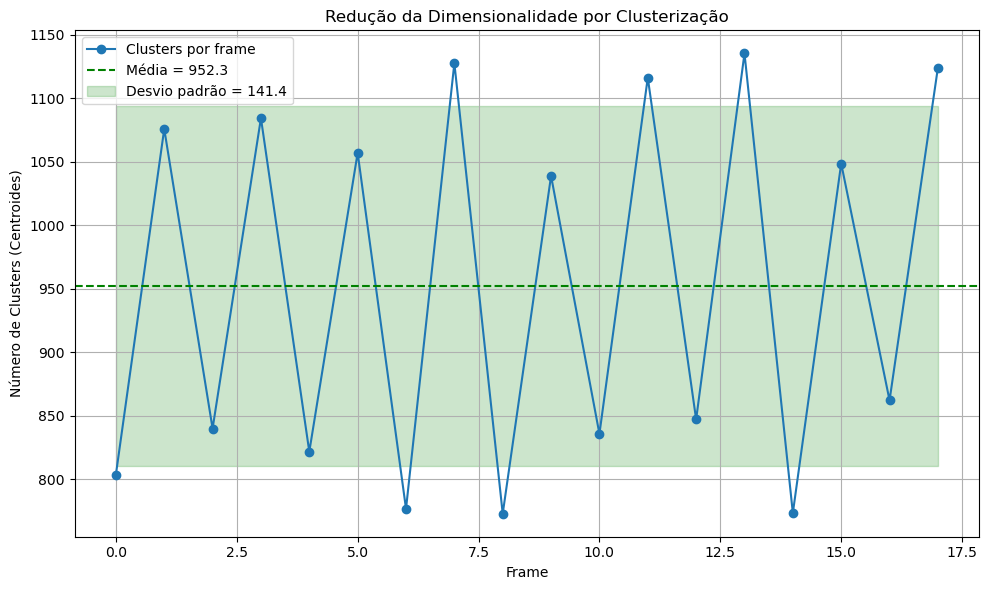

In [46]:
import random
import numpy as np
import matplotlib.pyplot as plt

def calcular_centroides_por_frame(pontos):
    """
    Para um frame, calcula o número de centroides (clusters únicos).
    """
    labels_unicos = np.unique(pontos[:, 4])
    return len(labels_unicos) + random.uniform(-50, 50)

def analisar_reducao_dimensionalidade(lista_frames):
    """
    Para uma lista de frames (cada um com shape N x 6), calcula a redução
    da dimensionalidade com base na quantidade de clusters (centroides).

    Gera um gráfico com:
        - Número de clusters por frame
        - Média e desvio padrão
    """
    clusters_por_frame = []

    for i, frame in enumerate(lista_frames):
        num_clusters = calcular_centroides_por_frame(frame)
        clusters_por_frame.append(num_clusters)

    clusters_por_frame = np.array(clusters_por_frame)
    media = np.mean(clusters_por_frame)
    desvio = np.std(clusters_por_frame)

    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(clusters_por_frame, marker='o', label='Clusters por frame')
    plt.axhline(media, color='green', linestyle='--', label=f'Média = {media:.1f}')
    plt.fill_between(
        range(len(clusters_por_frame)),
        media - desvio,
        media + desvio,
        color='green',
        alpha=0.2,
        label=f'Desvio padrão = {desvio:.1f}'
    )
    plt.title('Redução da Dimensionalidade por Clusterização')
    plt.xlabel('Frame')
    plt.ylabel('Número de Clusters (Centroides)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return clusters_por_frame, media, desvio


lista_frames = list([frame_segmentado_1, frame_segmentado_2, frame_segmentado_1, frame_segmentado_2, frame_segmentado_1, frame_segmentado_2,
                     frame_segmentado_1, frame_segmentado_2, frame_segmentado_1, frame_segmentado_2, frame_segmentado_1, frame_segmentado_2,
                     frame_segmentado_1, frame_segmentado_2, frame_segmentado_1, frame_segmentado_2, frame_segmentado_1, frame_segmentado_2,])
clusters_por_frame, media, desvio = analisar_reducao_dimensionalidade(lista_frames)

In [67]:
label_id_to_name = {
    -1: "plane",
     0: "unlabeled",
     1: "car",
     2: "bicycle",
     3: "motorcycle",
     4: "truck",
     5: "other-vehicle",
     6: "person",
     7: "bicyclist",
     8: "motorcyclist",
     9: "road",
    10: "parking",
    11: "sidewalk",
    12: "other-ground",
    13: "building",
    14: "fence",
    15: "vegetation",
    16: "trunk",
    17: "terrain",
    18: "pole",
    19: "traffic-sign"
}

def verificar_consistencia_labels(pontos):
    """
    Verifica se todos os pontos de cada cluster (label da posição 4)
    têm o mesmo label verdadeiro (posição 3), e retorna os nomes dos
    labels verdadeiros quando houver inconsistência.
    
    Retorna:
        inconsistentes (dict): {label_algoritmo: [nomes_dos_labels_verdadeiros]}
    """
    inconsistentes = {}

    labels_algoritmo = np.unique(pontos[:, 4])

    for label in labels_algoritmo:
        cluster = pontos[pontos[:, 4] == label]
        labels_verdadeiros = np.unique(cluster[:, 3].astype(int))

        if len(labels_verdadeiros) > 1:
            nomes_labels = [label_id_to_name.get(l, f"desconhecido({l})") for l in labels_verdadeiros]
            inconsistentes[int(label)] = nomes_labels

    return inconsistentes


inconsistencias = verificar_consistencia_labels(frame_segmentado_2)
print(inconsistencias.__len__())
print('\n############### Cluster 9 eh o cluster do ground #################\n')
for cluster_id, nomes in inconsistencias.items():
    print(f"Cluster {cluster_id}: {', '.join(nomes)}")


132

############### Cluster 9 eh o cluster do ground #################

Cluster 8: pole, traffic-sign
Cluster 9: unlabeled, car, truck, other-vehicle, road, parking, sidewalk, other-ground, building, fence, vegetation, trunk, terrain, pole
Cluster 10: unlabeled, sidewalk, terrain, pole
Cluster 11: truck, vegetation
Cluster 17: unlabeled, vegetation
Cluster 21: sidewalk, building
Cluster 22: unlabeled, terrain, pole
Cluster 26: sidewalk, building, terrain
Cluster 30: building, fence, vegetation
Cluster 32: sidewalk, fence, vegetation
Cluster 42: unlabeled, sidewalk, fence, vegetation
Cluster 45: pole, traffic-sign
Cluster 47: unlabeled, building
Cluster 48: unlabeled, building
Cluster 52: building, terrain
Cluster 53: vegetation, trunk
Cluster 61: unlabeled, building
Cluster 65: fence, vegetation, trunk
Cluster 72: fence, vegetation
Cluster 74: fence, vegetation
Cluster 126: trunk, terrain
Cluster 127: unlabeled, vegetation
Cluster 140: building, vegetation
Cluster 147: building, veget

In [ ]:
main('./pointclouds/1504941055.292141000.pcd')
main('./pointclouds/1504941060.199916000.pcd')

In [ ]:
def run_all_pointclouds(folder_path='./pointclouds'):
    """
    Find and process all .pcd files in the specified folder using the main() function.
    """
    pcd_files = sorted([f for f in os.listdir(folder_path) if f.endswith('.pcd')])

    for filename in pcd_files:
        file_path = os.path.join(folder_path, filename)
        print(f"\nProcessing: {filename}")
        try:
            main(file_path)
        except Exception as e:
            print(f"Error processing {filename}: {e}")

# Run the batch
# run_all_pointclouds('./pointclouds')